In [1]:
import pandas as pd
import numpy as np
import pickle
import os

import torch
import warnings
warnings.filterwarnings("ignore")
torch.__version__

pd.set_option('display.max_rows', 200)

In [2]:
DATAPATH = '/root/autodl-tmp'
TARGET = 'who_cn'

data = pd.read_csv(os.path.join(DATAPATH, '150M_training_data.csv'))[['id', TARGET, 'content']]

print(data.shape)

(1532268, 3)


In [3]:
# cnt = data[TARGET].value_counts(normalize = True)

# data = data[data[TARGET].isin(cnt[cnt>0.00005].index)]

# data[TARGET].nunique()

In [4]:
embedings = {}
for filename in os.listdir('/root/Pepsi/data/qwen2_05B_embeddings'):
  with open(f'/root/Pepsi/data/qwen2_05B_embeddings/{filename}', 'rb') as f:
    embedings.update(pickle.load(f))

In [5]:
data['embed'] = data['id'].apply(lambda x: embedings[x])
del embedings

In [6]:
# pd.DataFrame([data[TARGET].value_counts(normalize = True), data[TARGET].value_counts()]).T.to_csv('tmp.csv')

In [7]:
DATA_SIZE = 200000 
TRAIN_TEST_RATIO = 0.15
SEED = 3075


from sklearn.model_selection import train_test_split

if DATA_SIZE:
    train = data.sample(DATA_SIZE, random_state = SEED)
else:
    train = data

lost_targets = set(data[TARGET].unique()).difference(train[TARGET].unique())

lost_data = data[data[TARGET].isin(lost_targets)]

train = pd.concat([train, lost_data], axis = 0)


cnt = train[TARGET].value_counts()
train_less_than_2 = train[train[TARGET].isin(cnt[cnt<=2].index)]
train = train[train[TARGET].isin(cnt[cnt>2].index)]

train, test = train_test_split(train, stratify = train[TARGET], test_size = TRAIN_TEST_RATIO, random_state = SEED, shuffle = True)
train, val = train_test_split(train, stratify = train[TARGET], test_size = TRAIN_TEST_RATIO, random_state = SEED, shuffle = True)

val = pd.concat([val, train_less_than_2], axis = 0)
train = pd.concat([train, train_less_than_2], axis = 0)

print(train.shape)
print(val.shape)
print(test.shape)


display(
        pd.DataFrame([
            train[TARGET].value_counts(normalize = True),
            train[TARGET].value_counts(),
        ]).T
    )

(144503, 4)
(25509, 4)
(29999, 4)


,proportion,count
who_cn,,
其他,0.622769,89992.0
家人,0.107223,15494.0
Others,0.097257,14054.0
上班族,0.026352,3808.0
学生,0.022643,3272.0
朋友,0.020249,2926.0
女性,0.017654,2551.0
健身人士,0.012401,1792.0
养生人群,0.010491,1516.0


In [11]:
train_X = train['embed'].values.tolist()
train_X = np.array(train_X)
train_y = train[TARGET].values

val_X = val['embed'].values.tolist()
val_X = np.array(val_X)
val_y = val[TARGET].values

test_X = test['embed'].values.tolist()
test_X = np.array(test_X)
test_y = test[TARGET].values

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = OneHotEncoder(sparse_output=False)
train_encoded_y = label_encoder.fit_transform(train_y.reshape(-1,1))
val_encoded_y = label_encoder.transform(val_y.reshape(-1,1))
test_encoded_y = label_encoder.transform(test_y.reshape(-1,1))

In [13]:
INPUT_SHAPE = train_X[0].shape[0]


OUTPUT_SIZE = pd.Series(train_y).nunique()

print(INPUT_SHAPE, OUTPUT_SIZE)

896 35


In [11]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import Sequential, Model, layers

# train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_encoded_y))
# val_dataset = tf.data.Dataset.from_tensor_slices((val_X, val_encoded_y))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_X, test_encoded_y))

In [12]:
from tensorflow.keras import Sequential, Model, layers
import tensorflow as tf

tf.config.list_physical_devices('GPU')

2024-06-26 01:02:46.837724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 01:02:48.006716: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-26 01:02:48.006838: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-06-26 01:02:48.006848: W 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
# inputs = layers.Input(shape = (INPUT_SHAPE))

# x_ = layers.Dense(128, activation = 'linear', name = 'ffn1')(inputs)
# x = layers.Dropout(.5)(x_)
# x = layers.LayerNormalization(name = 'layernorm1')(x)
# x = layers.Dense(128, activation = 'relu', name = 'ffn2')(x)
# x = layers.Dropout(.5)(x)
# x = layers.LayerNormalization(name = 'layernorm2')(x)

# x = layers.Add()([x, x_])

# x = layers.Dense(OUTPUT_SIZE, activation = 'softmax', name = 'classification_header')(x)

# model = tf.keras.Model(inputs=inputs, outputs=x)

# model.compile(
#     loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy']
# )
# model.summary()

In [21]:
tf.random.set_seed(3407)


model = Sequential(
    [
        layers.Input(shape = (INPUT_SHAPE)),
        layers.Dense(INPUT_SHAPE, activation = 'linear', name = 'ffn1', kernel_initializer=tf.keras.initializers.GlorotUniform(seed=3407)),
        # layers.Dropout(.5),
        # layers.LayerNormalization(),
        # layers.Dense(768, activation = 'relu'),
        layers.LayerNormalization(name = 'layernorm1'),
        layers.Dropout(.5, name = 'dropout1'),
        # layers.Dense(64, activation = 'relu'),
        # layers.Dropout(.5),
        layers.Dense(OUTPUT_SIZE, activation = 'softmax', name = 'classification_header')
    ]
)


model.compile(
    loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy']
             
             )
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ffn1 (Dense)                (None, 896)               803712    
                                                                 
 layernorm1 (LayerNormalizat  (None, 896)              1792      
 ion)                                                            
                                                                 
 dropout1 (Dropout)          (None, 896)               0         
                                                                 
 classification_header (Dens  (None, 150)              134550    
 e)                                                              
                                                                 
Total params: 940,054
Trainable params: 940,054
Non-trainable params: 0
_________________________________________________________________


In [22]:
from datetime import datetime as dt 

os.makedirs(f'{DATAPATH}/{TARGET}', exist_ok = True)

timestamp = dt.now().strftime("%Y%m%d%H%M%S")


with open(f'{DATAPATH}/{TARGET}/{timestamp}-label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

tf.random.set_seed(3407)

history = model.fit(
    train_X, train_encoded_y, epochs = 500,
    batch_size = 64,
    validation_data = (val_X, val_encoded_y),
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience= 100),
        tf.keras.callbacks.ModelCheckpoint(f'{DATAPATH}/{TARGET}/{timestamp}', save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir=f'/root/tf-logs/{TARGET}/{timestamp}/', histogram_freq=1)
        #TestCallback(test_dataset.batch(64), None)
    ],
    # class_weight = class_weight
)

Epoch 1/500
2260/2260 [==============================] - 13s 5ms/step - loss: 1.9413 - accuracy: 0.4081 - val_loss: 1.7742 - val_accuracy: 0.4468
Epoch 2/500
2260/2260 [==============================] - 9s 4ms/step - loss: 1.7716 - accuracy: 0.4381 - val_loss: 1.7905 - val_accuracy: 0.4129
Epoch 3/500
2260/2260 [==============================] - 10s 5ms/step - loss: 1.7370 - accuracy: 0.4444 - val_loss: 1.7155 - val_accuracy: 0.4540
Epoch 4/500
2260/2260 [==============================] - 10s 5ms/step - loss: 1.7143 - accuracy: 0.4499 - val_loss: 1.7012 - val_accuracy: 0.4549
Epoch 5/500
2260/2260 [==============================] - 10s 5ms/step - loss: 1.6980 - accuracy: 0.4532 - val_loss: 1.6949 - val_accuracy: 0.4566
Epoch 6/500
2260/2260 [==============================] - 11s 5ms/step - loss: 1.6853 - accuracy: 0.4555 - val_loss: 1.6859 - val_accuracy: 0.4593
Epoch 7/500
2260/2260 [==============================] - 10s 4ms/step - loss: 1.6745 - accuracy: 0.4578 - val_loss: 1.6906 - 

In [14]:
model.save(f'{DATAPATH}/{TARGET}/{timestamp}_final')


NameError: name 'model' is not defined

In [25]:
# model = tf.keras.models.load_model(f'{DATAPATH}/{TARGET}/{timestamp}')

model_path = f'{DATAPATH}/{TARGET}/{timestamp}'
# model_path = f'{DATAPATH}/{TARGET}/20240626003142'

model = tf.keras.models.load_model(model_path)

output_result_path = f'results/{TARGET}/{model_path.split("/")[-1]}'

with open(f'{model_path}-label_encoder.pkl', 'rb') as f :
    label_encoder = pickle.load(f)


model.evaluate(test_X, test_encoded_y)



938/938 [==============================] - 2s 3ms/step - loss: 1.6096 - accuracy: 0.4818


[1.6096433401107788, 0.4817739427089691]

In [26]:
test_y_pred = model.predict(test_X)
# test_y_pred = tf.one_hot(test_y_pred, 30)
test_y_pred = label_encoder.inverse_transform(test_y_pred).reshape(1,-1)[0]

938/938 [==============================] - 2s 2ms/step


In [17]:
# from scipy.sparse import csr_matrix
# from scipy.sparse.csgraph import reverse_cuthill_mckee

# graph = csr_matrix(cm_prec)

# output = reverse_cuthill_mckee(graph, symmetric_mode=False)

# output

# labels=[i for i in list(map(lambda x: x[3:] , label_encoder.get_feature_names_out())) if i in test_y]

# order = sorted(list(range(len(labels))), key = lambda x: output[x], reverse = True)
# cm_prec = cm/cm.sum(axis=0)


# order_label = []

# for i,l  in enumerate(labels):
#     order_label



# # ax = hierarchy.dendrogram(Z, show_contracted=True, )

# # cm_prec

# labels = sorted(labels, key = lambda x: output[labels.index(x)], reverse = True)

# cm_prec_reorder = cm_prec[:,order]
# cm_prec_reorder = cm_prec_reorder[order,:]

NameError: name 'cm_prec' is not defined

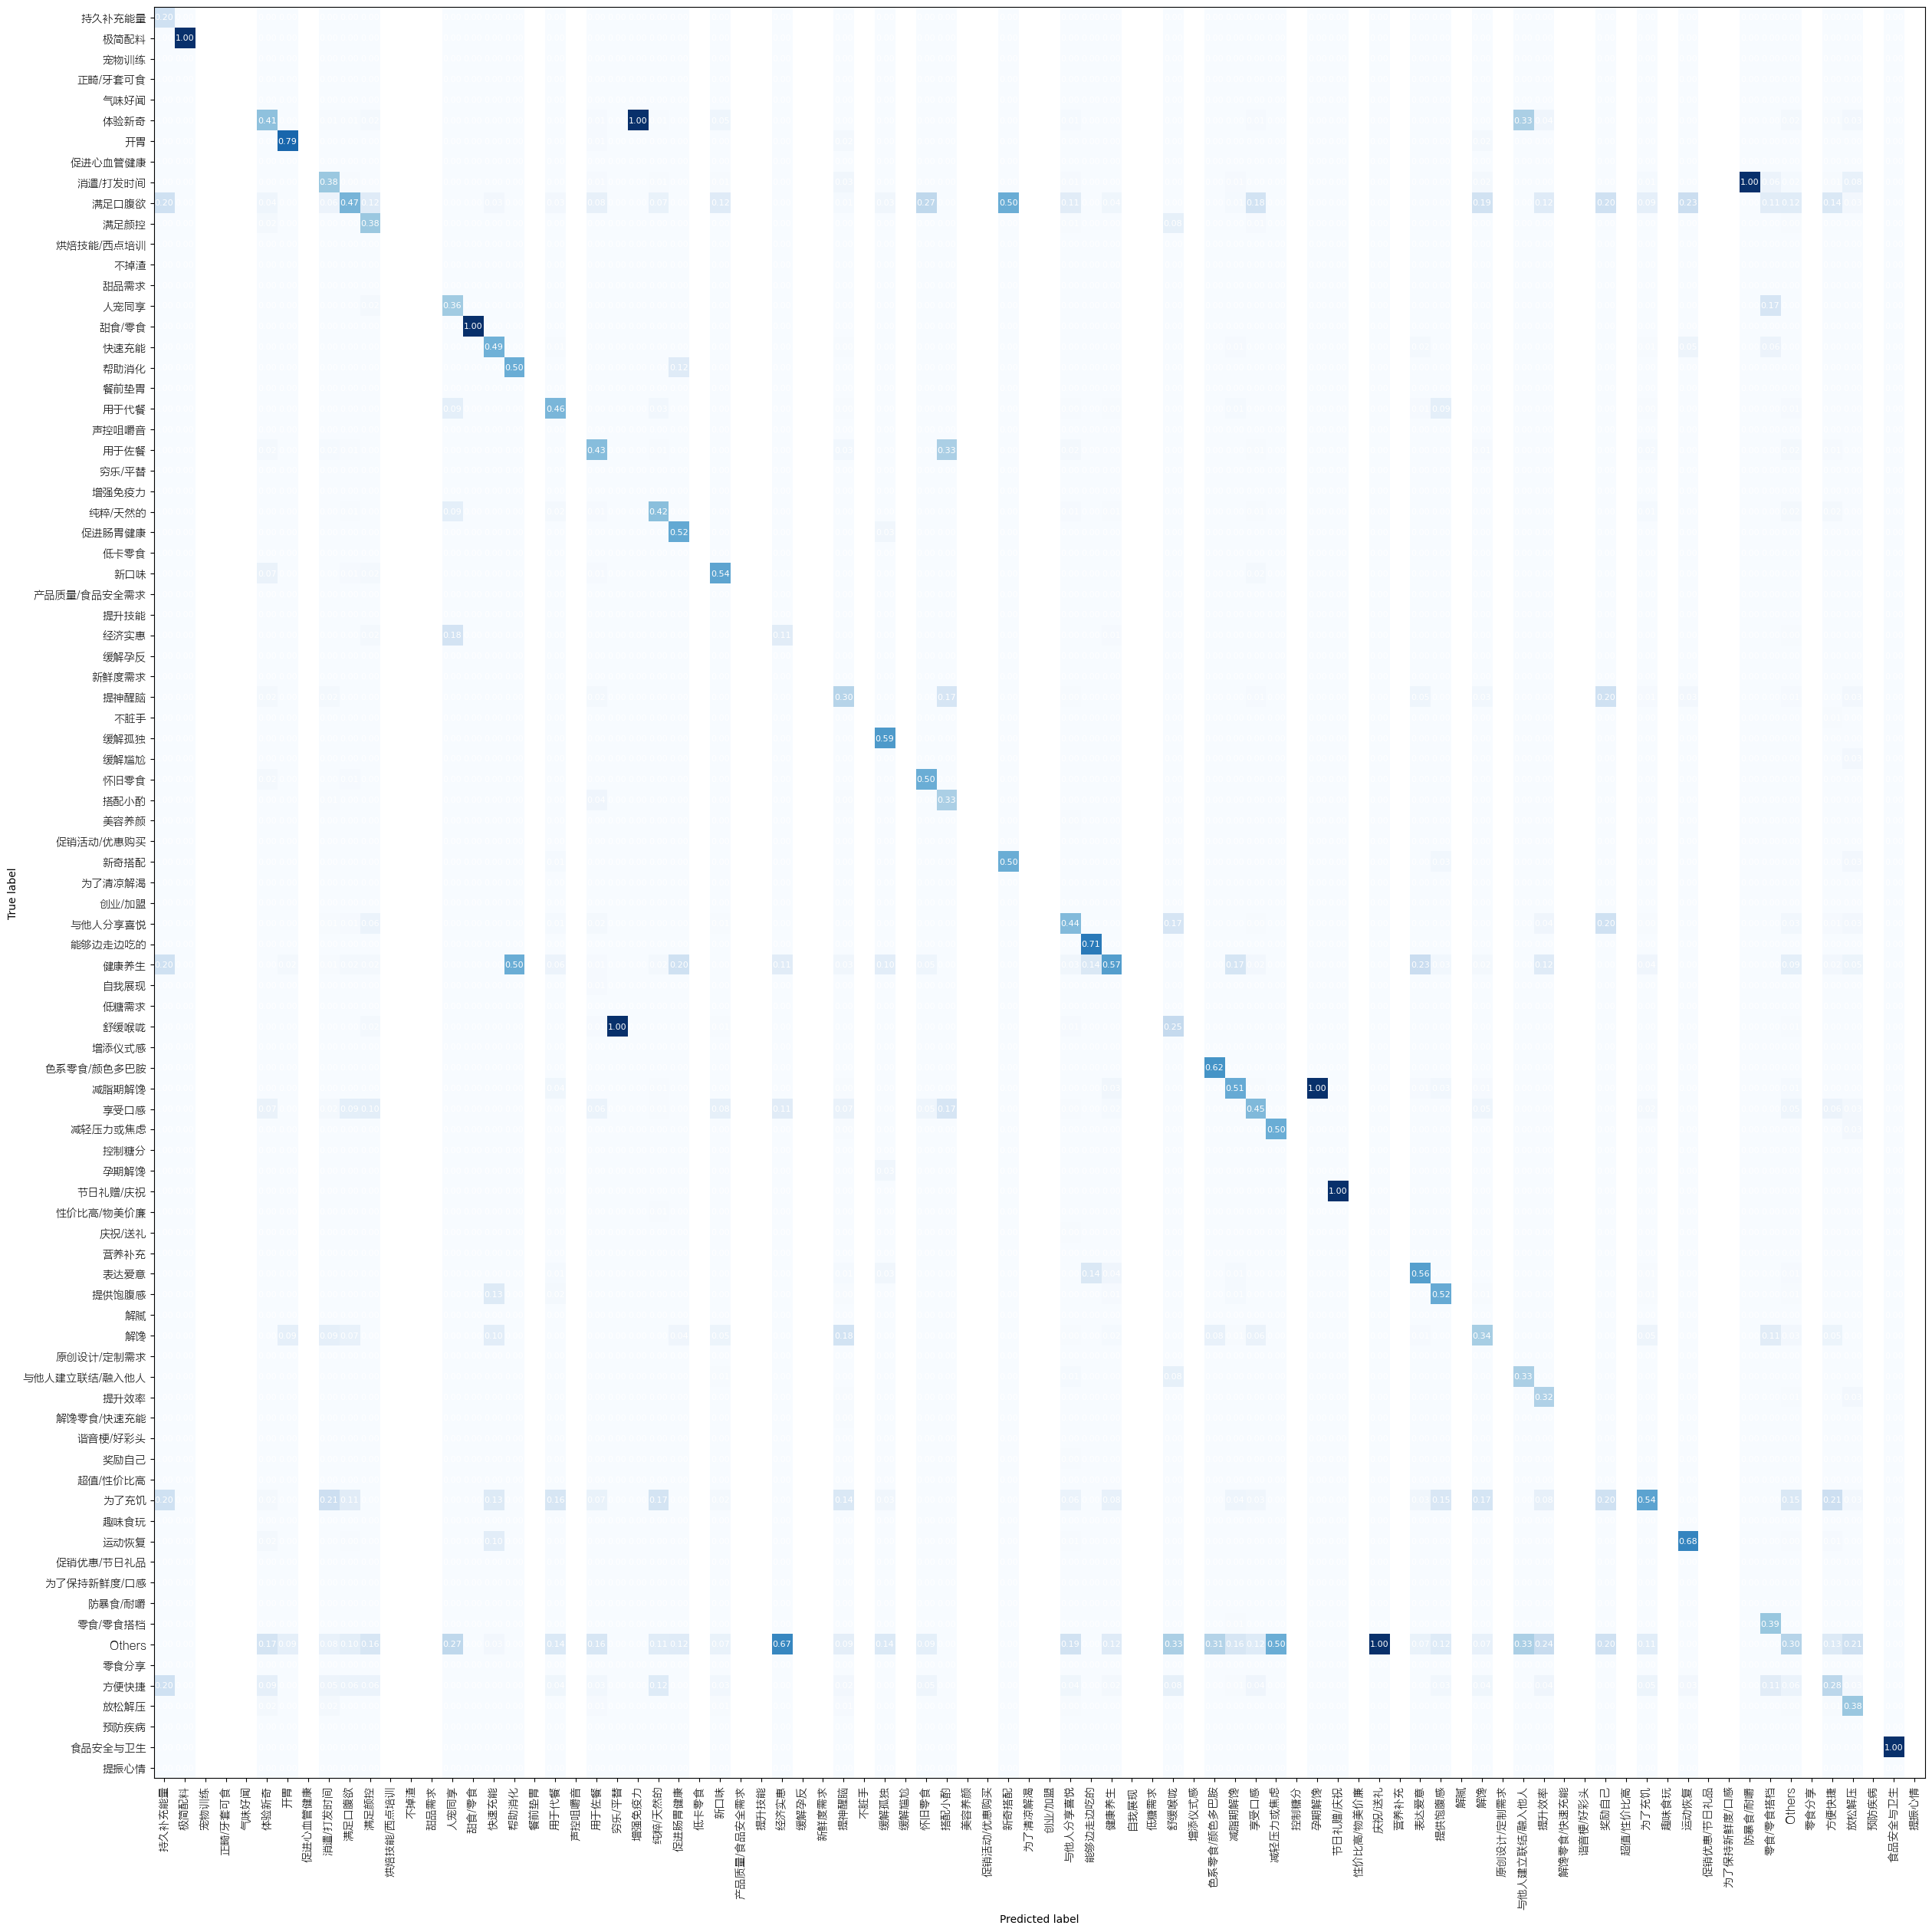

In [31]:
import matplotlib.font_manager as fm
font_path = '/root/social-listening-toolkit/project_support/Pepsico/notebooks/STHeiti-Medium.ttf'
import matplotlib
import matplotlib.pyplot as plt 

my_font = fm.FontProperties(fname=font_path)  # get the font based on the font_path

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee


cm = confusion_matrix(test_y, test_y_pred)
cm_prec = cm/cm.sum(axis=0)
graph = csr_matrix(cm_prec)
output = reverse_cuthill_mckee(graph, symmetric_mode=False)


labels=[i for i in list(map(lambda x: x[3:] , label_encoder.get_feature_names_out())) if i in test_y]

order = sorted(list(range(len(labels))), key = lambda x: output[x], reverse = True)


order_label = []

for i,l  in enumerate(labels):
    order_label


labels = sorted(labels, key = lambda x: output[labels.index(x)], reverse = True)

cm_prec_reorder = cm_prec[:,order]
cm_prec_reorder = cm_prec_reorder[order,:]


a = ConfusionMatrixDisplay(cm_prec_reorder)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (36,30))
a.display_labels = labels
a.plot(cmap= 'Blues', colorbar=False, ax = ax, values_format = '.2f' ,text_kw = dict(color = 'white', size = 8))
ax.tick_params(axis='x', labelrotation=90)
for label in ax.get_xticklabels():
    label.set_fontproperties(my_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(my_font)
fig.show()

os.makedirs(output_result_path, exist_ok=True)
fig.savefig(f'{output_result_path}/cm.png')

In [20]:
# import matplotlib.font_manager as fm
# font_path = '/root/social-listening-toolkit/project_support/Pepsico/notebooks/STHeiti-Medium.ttf'
# import matplotlib
# import matplotlib.pyplot as plt 

# my_font = fm.FontProperties(fname=font_path)  # get the font based on the font_path

# from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# cm = confusion_matrix(test_y, test_y_pred)
# a = ConfusionMatrixDisplay(cm/cm.sum(axis=0))
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize = (36,30))
# a.display_labels = [i for i in list(map(lambda x: x[3:] , label_encoder.get_feature_names_out())) if i in test_y]
# a.plot(cmap= 'Blues', colorbar=False, ax = ax, values_format = '.2f' ,text_kw = dict(color = 'white', size = 8))
# ax.tick_params(axis='x', labelrotation=90)
# for label in ax.get_xticklabels():
#     label.set_fontproperties(my_font)
# for label in ax.get_yticklabels():
#     label.set_fontproperties(my_font)
# fig.show()

# os.makedirs(output_result_path, exist_ok=True)
# fig.savefig(f'{output_result_path}/cm.png')

In [27]:
(
    pd.DataFrame({'index':test_y_pred, 'acc':test_y == test_y_pred}).groupby('index').mean()
    .join(pd.DataFrame({'index':test_y, 'target count':test_y == test_y_pred}).groupby('index').count(), how = 'outer')
    .join(pd.DataFrame({'index':test_y_pred, 'prediction count': test_y_pred}).groupby('index').count(), how = 'outer')
    .join(pd.DataFrame({'index':test_y_pred, 'prediction true': (test_y == test_y_pred).astype(int)}).groupby('index').sum(), how = 'outer')
    .sort_values('target count', ascending = False)

)

,acc,target count,prediction count,prediction true
index,,,,
为了充饥,0.543903,6889.0,8439.0,4590.0
满足口腹欲,0.470287,6152.0,9373.0,4408.0
Others,0.298785,3797.0,2634.0,787.0
健康养生,0.568543,3544.0,4406.0,2505.0
解腻,0.344905,1694.0,893.0,308.0
享受口感,0.447496,1619.0,619.0,277.0
方便快捷,0.278863,1557.0,563.0,157.0
减脂期解馋,0.513661,714.0,915.0,470.0
与他人分享喜悦,0.444227,469.0,511.0,227.0


In [28]:
m = tf.keras.metrics.TopKCategoricalAccuracy(k=5)
m.update_state(label_encoder.transform(test_y.reshape(-1,1)),
               model.predict(test_X))
m.result()

938/938 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.9037385>

In [32]:
test_rst = pd.DataFrame({'id': test['id'].values, 'content': test['content'].values,'true': test_y,'pred':test_y_pred, 'acc':test_y == test_y_pred})
test_rst_wrong = test_rst[~test_rst['acc']]


test_rst_wrong.to_csv(f"{output_result_path}/badcase.csv", index = False)

In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# x_pca = pca.fit_transform(embedings)
embedding_layers = tf.keras.Sequential(model.layers[:-1])
test_embedings = embedding_layers(test_X)
tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30)
x_pca_after = tsne.fit_transform(test_embedings)

color_ls = px.colors.qualitative.Dark24

class_name_ls = pd.unique(test_y).tolist()


color_dict = {t:c  for t, c in zip(class_name_ls,color_ls)}


fig = px.scatter(x=x_pca_after[:,0], y=x_pca_after[:,1], color = test[TARGET], opacity = .6)


fig.update_layout(template = 'simple_white', width = 1000, height = 700)

In [ ]:
import plotly.express as px
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# x_pca = pca.fit_transform(embedings)

tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30)
x_pca = tsne.fit_transform(test_X)

color_ls = px.colors.qualitative.Dark24

class_name_ls = pd.unique(test_y).tolist()


color_dict = {t:c  for t, c in zip(class_name_ls,color_ls)}


fig = px.scatter(x=x_pca[:,0], y=x_pca[:,1], color = test[TARGET], opacity = .6)


fig.update_layout(template = 'simple_white', width = 1000, height = 700)